# MNIST (Partial) Side Quests?

This notebook builds off the ideas from the `MNIST Side Quests` notebook. In this experiment, we allow the network to have some more freedom in how to use the "side quest" information. Instead of using the sub losses to take a step for each sub layer, we will use the sub losses to add to the total loss. This is somewhere between pursuing just the main quest and pursuing the side quests, at least 50% effort (for each side quest).

## Imports

In [1]:
import random

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

from helpers import load_images, load_labels, visualize_image, get_edges, generate_intermediate_edge_labels

## Globals

In [2]:
MODEL_NAME = "./temp.pth"

## Set Device to GPU

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We will be using device: {device}")

We will be using device: cuda


## Load Data

In [4]:
# train data
train_images = load_images("./data/train-images-idx3-ubyte/train-images-idx3-ubyte")
train_labels = load_labels("./data/train-labels-idx1-ubyte/train-labels-idx1-ubyte")

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels,
    test_size=1/6,  # 10k validation
    stratify=train_labels,
    random_state=42  # for reproducibility
)

# test data
test_images = load_images("./data/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte")
test_labels = load_labels("./data/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte")

In [5]:
print("Train images shape:", train_images.shape)
print("Val images shape:", val_images.shape)
print("Test images shape:", test_images.shape)

Train images shape: (50000, 28, 28)
Val images shape: (10000, 28, 28)
Test images shape: (10000, 28, 28)


## Visualize an image

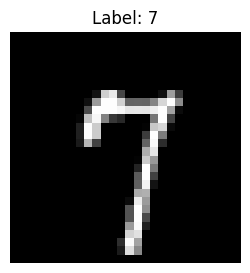

In [6]:
sample_image = train_images[0]
sample_label = train_labels[0]
visualize_image(sample_image, sample_label)

## Convolutions to get Horizontal Edges

### Example Image

In [7]:
horizontal_kernel = np.array([
    [-1, -1, -1],
    [ 0,  0 , 0],
    [ 1,  1,  1],
])

In [8]:
horizontal_edges = get_edges(horizontal_kernel, sample_image)

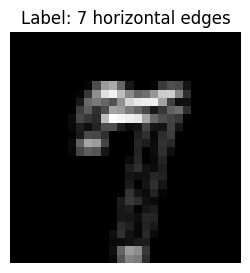

In [9]:
visualize_image(horizontal_edges, f"{sample_label} horizontal edges")

### Extending the Dataset

In [10]:
train_horizontal_image_labels = generate_intermediate_edge_labels(train_images, horizontal_kernel)

In [11]:
val_horizontal_image_labels = generate_intermediate_edge_labels(val_images, horizontal_kernel)

In [12]:
test_horizontal_image_labels = generate_intermediate_edge_labels(test_images, horizontal_kernel)

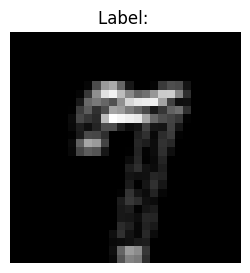

In [13]:
visualize_image(train_horizontal_image_labels[0].reshape(28, 28), "")

## Convolutions to get Vertical Edges

### Example Image

In [14]:
vertical_kernel = np.array([
    [-1,  0,  1],
    [-1,  0,  1],
    [-1,  0,  1],
])

In [15]:
vertical_edges = get_edges(vertical_kernel, sample_image)

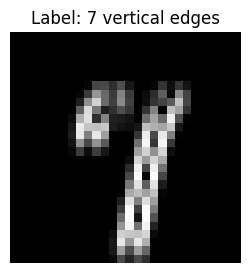

In [16]:
visualize_image(vertical_edges, f"{sample_label} vertical edges")

### Extending the Dataset

In [17]:
train_vertical_image_labels = generate_intermediate_edge_labels(train_images, vertical_kernel)

In [18]:
val_vertical_image_labels = generate_intermediate_edge_labels(val_images, vertical_kernel)

In [19]:
test_vertical_image_labels = generate_intermediate_edge_labels(test_images, vertical_kernel)

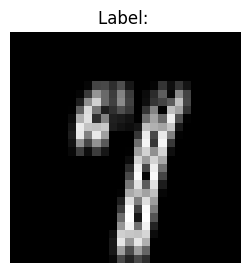

In [20]:
visualize_image(train_vertical_image_labels[0].reshape(28, 28), "")

# Our Test

## Architecture

We keep our two hidden layers at image size to be able to calculate a local loss to push those layers to learn human recognizable structures. However, for the example below, we don't calculate intermediate loss, as we need a basis.

In [21]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        layer_size_by_pixels = 28*28
        
        self.flatten = nn.Flatten()
        
        # define layers separately to have access to each
        self.horizontal_layer = nn.Linear(layer_size_by_pixels, layer_size_by_pixels)
        self.vertical_layer = nn.Linear(layer_size_by_pixels, layer_size_by_pixels)
        self.classification_layer = nn.Linear(layer_size_by_pixels, 10)
        self.activation_function = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)

        # horizontal layer
        horizontal_out = self.horizontal_layer(x)
        horizontal_act = self.activation_function(horizontal_out)

        # vertical layer connected to horizontal layer
        vertical_out = self.vertical_layer(horizontal_act)
        vertical_act = self.activation_function(vertical_out)

        # detached verision for vertical loss only
        # detached_input = horizontal_act.detach()
        # vertical_out_detached = self.vertical_layer(detached_input)
        # vertical_act_detached = self.activation_function(vertical_out_detached)

        # coupling layer
        classification_out = self.classification_layer(vertical_act)
        
        return classification_out, vertical_act, horizontal_act

In [22]:
# for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [23]:
model = NeuralNetwork().to(device)

# loss functions
classification_loss_fn = nn.CrossEntropyLoss()
horizontal_loss_fn = nn.MSELoss()
vertical_loss_fn = nn.MSELoss()

# optimizers
optimizer = torch.optim.Adam(model.parameters())

In [24]:
print(f"Model weights (to compare below): {model.horizontal_layer.weight[0][:5].detach().cpu().numpy()}")

Model weights (to compare below): [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]


### Verify Reproducibility

In [25]:
# reset the seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    
model_compare_one = NeuralNetwork().to(device)
first_set_of_weights = model_compare_one.horizontal_layer.weight[0][:5].detach().cpu().numpy()
print("First set of weights:", first_set_of_weights)

# reset the seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

model_compare_two = NeuralNetwork().to(device)
second_set_of_weights = model_compare_two.horizontal_layer.weight[0][:5].detach().cpu().numpy()
print("Second set of weights:", second_set_of_weights)

print(f"Are the two sets equal: {first_set_of_weights == second_set_of_weights}")

First set of weights: [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]
Second set of weights: [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]
Are the two sets equal: [ True  True  True  True  True]


## Dataloader

In [26]:
class EdgeDataset(Dataset):
    def __init__(self, images, labels, horizontal_edges, vertical_edges):
        self.images = images
        self.labels = labels
        self.horizontal_edges = horizontal_edges
        self.vertical_edges = vertical_edges

    def __len__(self):
        assert len(self.images) == len(self.labels)
        return len(self.images)

    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.images[idx].copy()).float(),
            torch.tensor(self.labels[idx].copy(), dtype=torch.long),
            torch.from_numpy(self.horizontal_edges[idx].copy()).float(),
            torch.from_numpy(self.vertical_edges[idx].copy()).float(),
        )

In [27]:
# for reproducibility on training
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

generator = torch.Generator().manual_seed(seed)

In [28]:
# training data
train_dataset = EdgeDataset(train_images, train_labels, train_horizontal_image_labels, train_vertical_image_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, worker_init_fn=seed_worker, generator=generator)

# validation data
val_dataset = EdgeDataset(val_images, val_labels, val_horizontal_image_labels, val_vertical_image_labels)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)  # larger batch size for faster validation

# test data
test_dataset = EdgeDataset(test_images, test_labels, test_horizontal_image_labels, test_vertical_image_labels)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

## Training Loop

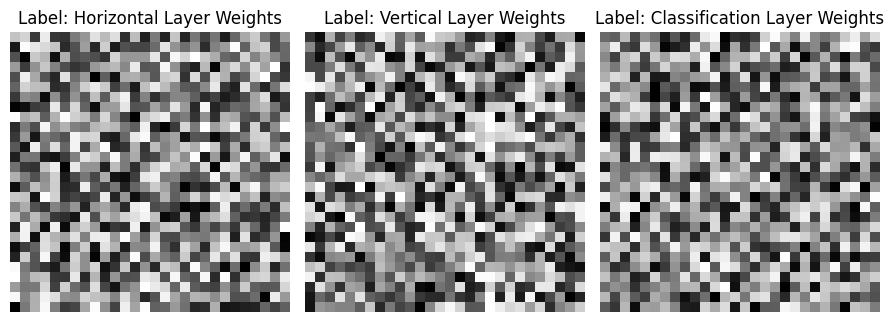

Epoch 1/20
  Train Loss: 27.9181
  Horizontal Edge Loss: 2.7361
  Vertical Edge Loss: 2.5589
  Val Loss: 0.9453 | Val Acc: 91.39%


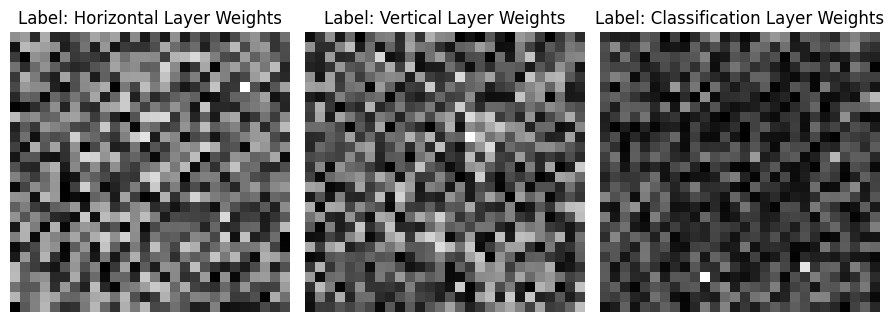

Epoch 2/20
  Train Loss: 21.5749
  Horizontal Edge Loss: 2.5397
  Vertical Edge Loss: 2.6341
  Val Loss: 0.6793 | Val Acc: 94.70%


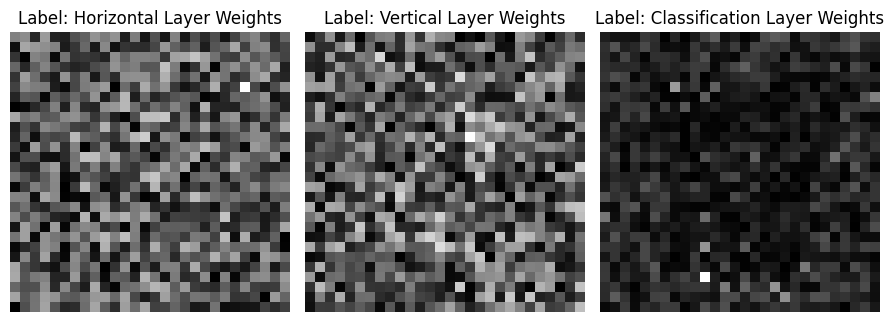

Epoch 3/20
  Train Loss: 20.0914
  Horizontal Edge Loss: 2.7253
  Vertical Edge Loss: 2.5828
  Val Loss: 0.9177 | Val Acc: 93.86%


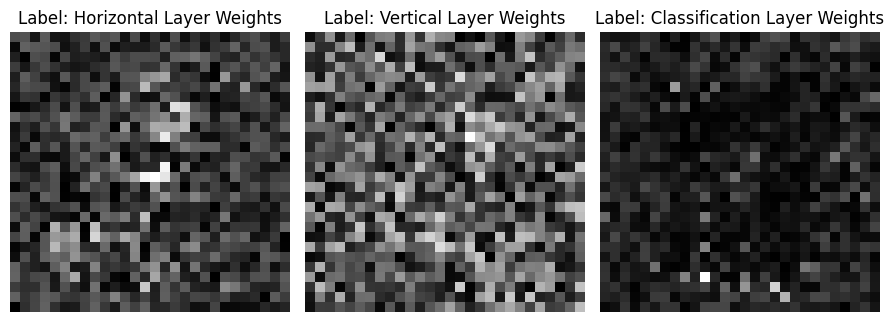

Epoch 4/20
  Train Loss: 19.3542
  Horizontal Edge Loss: 2.2176
  Vertical Edge Loss: 1.9698
  Val Loss: 1.2332 | Val Acc: 92.84%


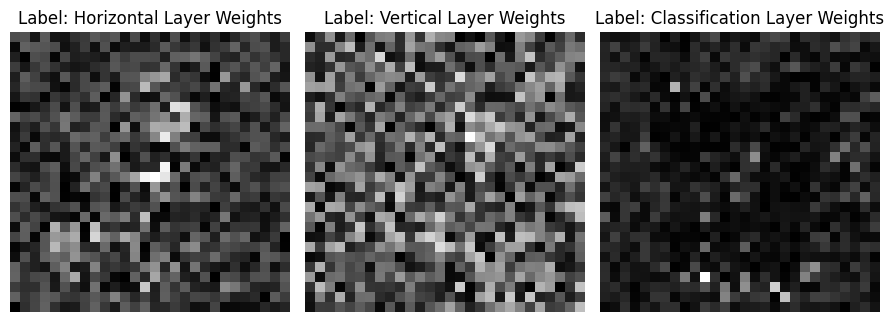

Epoch 5/20
  Train Loss: 18.9473
  Horizontal Edge Loss: 2.2458
  Vertical Edge Loss: 2.1049
  Val Loss: 1.0665 | Val Acc: 94.15%


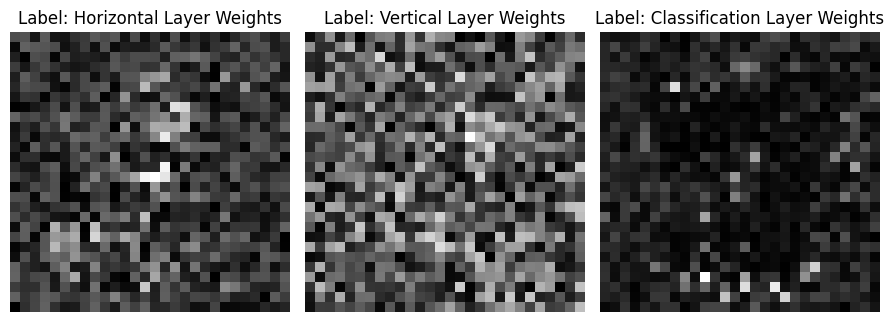

Epoch 6/20
  Train Loss: 18.6603
  Horizontal Edge Loss: 2.5096
  Vertical Edge Loss: 2.0856
  Val Loss: 0.9626 | Val Acc: 95.38%


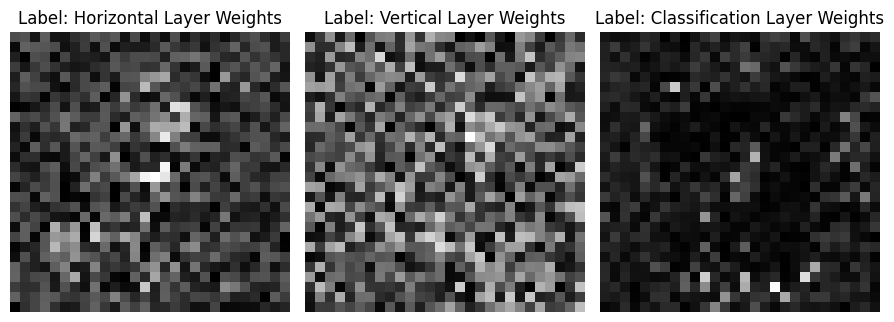

Epoch 7/20
  Train Loss: 18.4412
  Horizontal Edge Loss: 2.7033
  Vertical Edge Loss: 1.9846
  Val Loss: 1.1724 | Val Acc: 94.33%


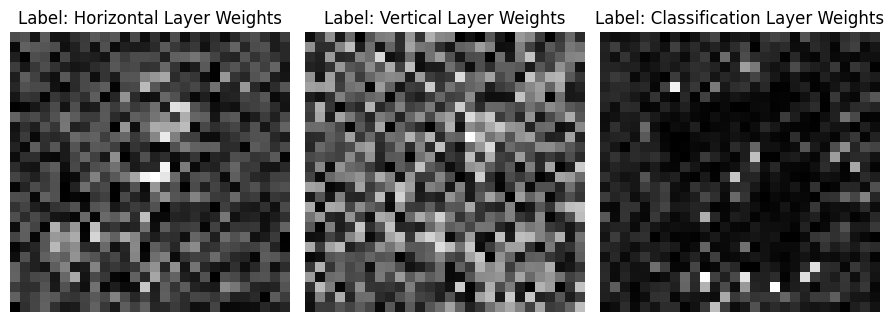

Epoch 8/20
  Train Loss: 18.1683
  Horizontal Edge Loss: 2.1532
  Vertical Edge Loss: 1.7408
  Val Loss: 1.4947 | Val Acc: 94.66%


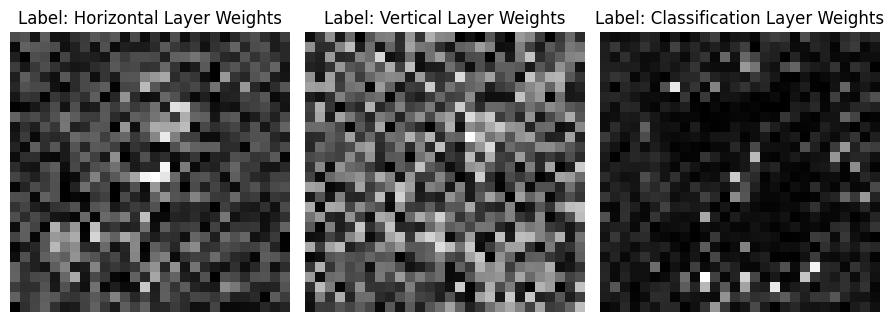

Epoch 9/20
  Train Loss: 18.0774
  Horizontal Edge Loss: 2.2084
  Vertical Edge Loss: 1.8797
  Val Loss: 1.6138 | Val Acc: 94.84%


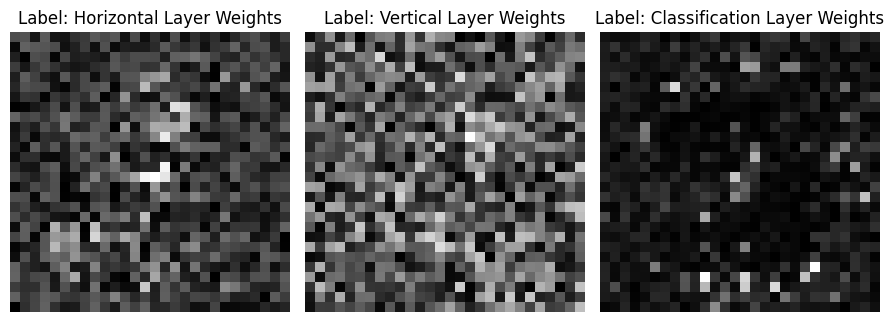

Epoch 10/20
  Train Loss: 17.9491
  Horizontal Edge Loss: 2.7636
  Vertical Edge Loss: 1.8363
  Val Loss: 1.3216 | Val Acc: 95.44%


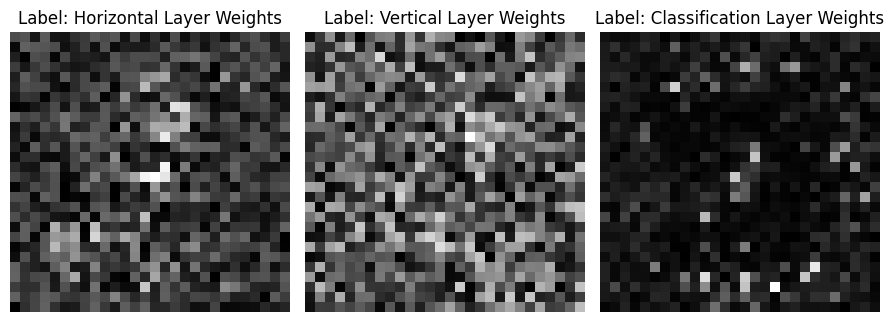

Epoch 11/20
  Train Loss: 17.8298
  Horizontal Edge Loss: 2.4427
  Vertical Edge Loss: 1.8037
  Val Loss: 1.5715 | Val Acc: 95.05%


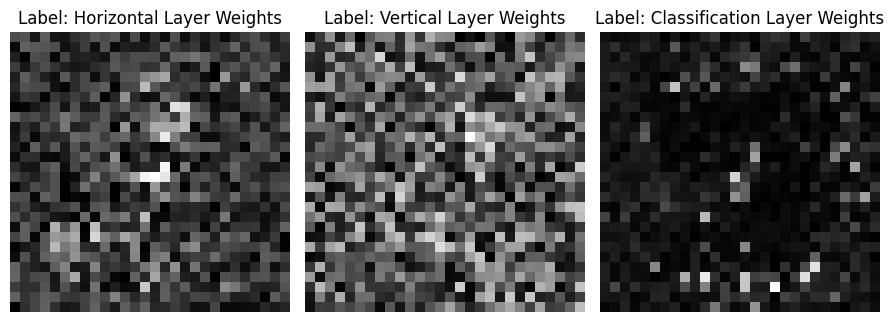

Epoch 12/20
  Train Loss: 17.8738
  Horizontal Edge Loss: 2.3433
  Vertical Edge Loss: 1.6244
  Val Loss: 1.4092 | Val Acc: 96.06%


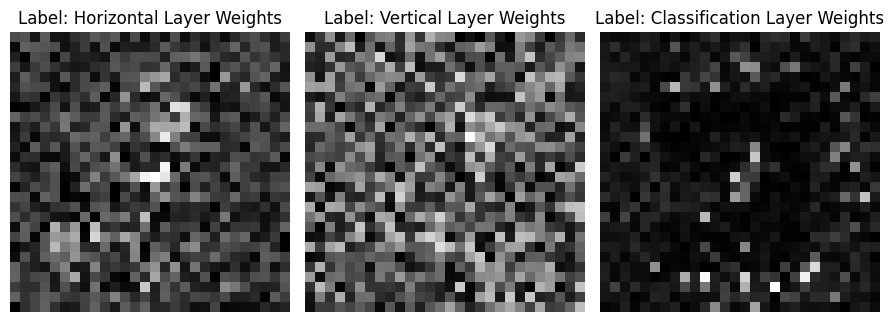

Epoch 13/20
  Train Loss: 17.7220
  Horizontal Edge Loss: 2.6043
  Vertical Edge Loss: 1.9414
  Val Loss: 1.6729 | Val Acc: 95.84%


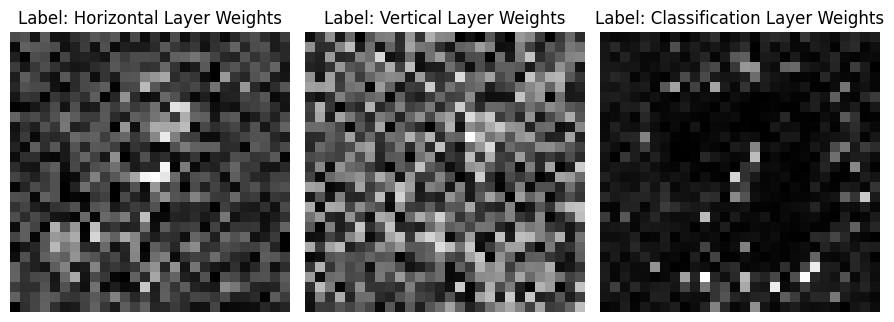

Epoch 14/20
  Train Loss: 17.9222
  Horizontal Edge Loss: 2.6273
  Vertical Edge Loss: 1.8371
  Val Loss: 1.8223 | Val Acc: 95.65%


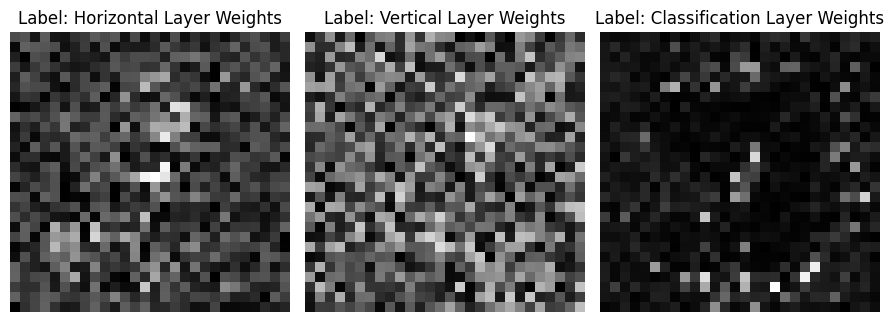

Epoch 15/20
  Train Loss: 17.7606
  Horizontal Edge Loss: 2.8101
  Vertical Edge Loss: 1.9707
  Val Loss: 1.8225 | Val Acc: 95.59%


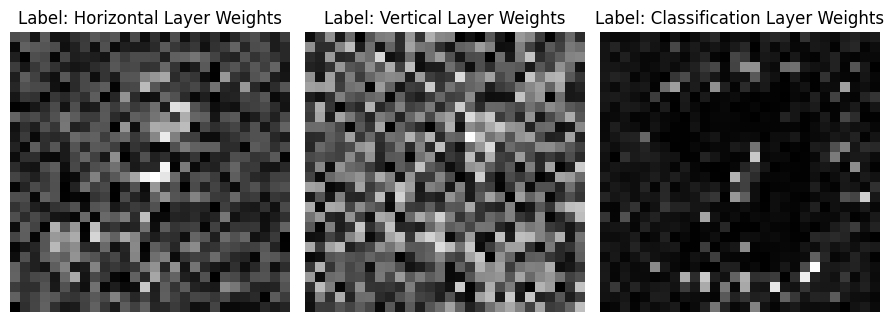

Epoch 16/20
  Train Loss: 17.8294
  Horizontal Edge Loss: 2.5553
  Vertical Edge Loss: 1.8183
  Val Loss: 1.8032 | Val Acc: 95.45%


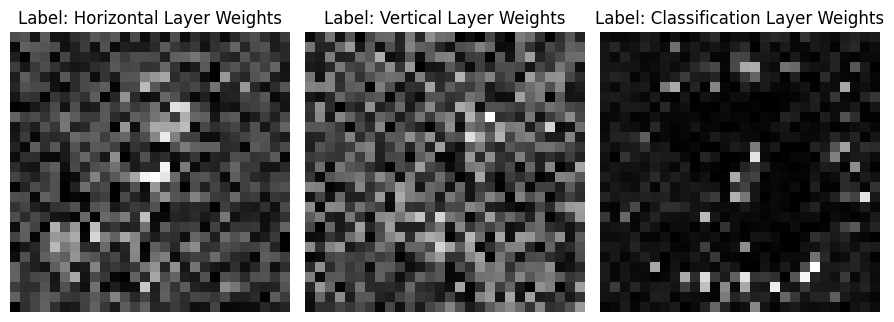

Epoch 17/20
  Train Loss: 17.6005
  Horizontal Edge Loss: 3.0430
  Vertical Edge Loss: 1.9802
  Val Loss: 1.7630 | Val Acc: 96.11%


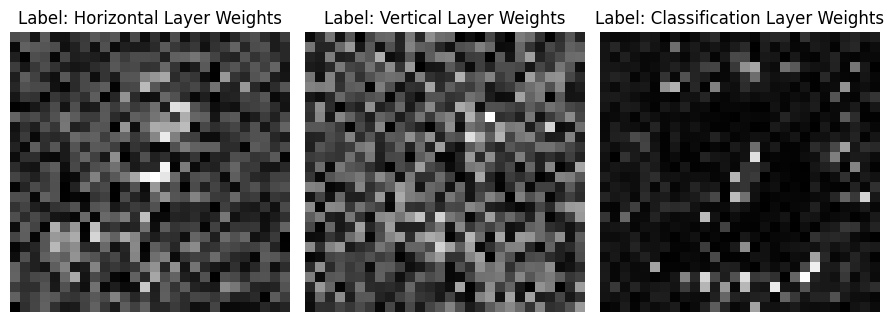

Epoch 18/20
  Train Loss: 18.0000
  Horizontal Edge Loss: 2.6314
  Vertical Edge Loss: 1.7201
  Val Loss: 1.9102 | Val Acc: 95.94%


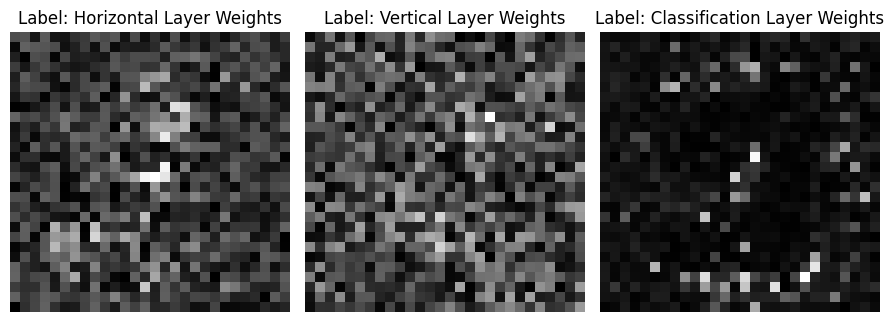

Epoch 19/20
  Train Loss: 17.8341
  Horizontal Edge Loss: 2.5591
  Vertical Edge Loss: 1.7661
  Val Loss: 1.9226 | Val Acc: 95.78%


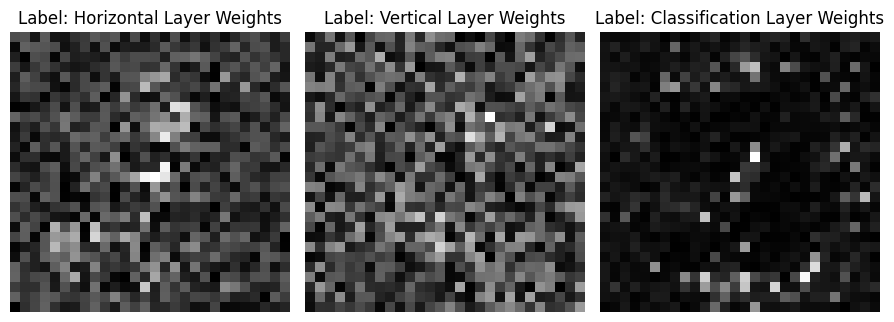

Epoch 20/20
  Train Loss: 17.9954
  Horizontal Edge Loss: 3.0845
  Vertical Edge Loss: 1.9266
  Val Loss: 1.7975 | Val Acc: 96.41%


In [29]:
num_epochs = 20
best_val_loss = float('inf')
for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()  # set the model to training mode - this is currently a no-op
    train_loss = 0.0

    # visualize weights at each layer during training
    classification_w = np.abs(model.classification_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
    vertical_w = np.abs(model.vertical_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
    horizontal_w = np.abs(model.horizontal_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
    
    fig, axes = plt.subplots(1, 3, figsize=(9, 5))
    
    visualize_image(horizontal_w, "Horizontal Layer Weights", ax=axes[0])
    visualize_image(vertical_w, "Vertical Layer Weights", ax=axes[1])
    visualize_image(classification_w, "Classification Layer Weights", ax=axes[2])
    
    plt.tight_layout()
    plt.show()

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]", leave=False)
    for batch in train_bar:
        # deconstruct batch items
        images, labels, horizontal_labels, vertical_labels = batch
        images, labels, horizontal_labels, vertical_labels = images.to(device), labels.to(device), horizontal_labels.to(device), vertical_labels.to(device)
        
        # forward pass
        classification_out, vertical_act, horizontal_act = model(images)
        
        # --- Loss and Backprop ---

        # clear gradients
        optimizer.zero_grad()

        # vertical loss
        vertical_loss = vertical_loss_fn(vertical_act, vertical_labels)

        # horizontal loss
        horizontal_loss = horizontal_loss_fn(horizontal_act, horizontal_labels)

        # classification loss
        classification_loss = classification_loss_fn(classification_out, labels)

        # total loss
        total_loss = 0.005 * (vertical_loss + horizontal_loss) + classification_loss
        total_loss.backward()
        
        optimizer.step()

        # update progress
        train_loss += total_loss.item()
        train_bar.set_postfix(loss=classification_loss.item())

    
    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for batch in val_bar:
            # deconstruct
            images, labels, _, _ = batch
            images, labels = images.to(device), labels.to(device)

            # forward pass
            classification_out, _, _ = model(images)

            # compute loss
            loss = classification_loss_fn(classification_out, labels)

            # calculate metrics
            val_loss += loss.item()
            _, predicted = torch.max(classification_out, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # epoch stats
    avg_train_loss = train_loss / len(train_loader)
    avg_horizontal_loss = horizontal_loss / len(train_loader)
    avg_vertical_loss = vertical_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Horizontal Edge Loss: {avg_horizontal_loss:.4f}")
    print(f"  Vertical Edge Loss: {avg_vertical_loss:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    # save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), MODEL_NAME)

## Eval

In [30]:
model.load_state_dict(torch.load(MODEL_NAME))
model.eval()  # again currently a no-op

test_correct = 0
test_total = 0

with torch.no_grad():
    test_bar = tqdm(test_loader, desc=f"Evaluation")
    for batch in test_bar:
        images, labels, _, _ = batch
        images, labels = images.to(device), labels.to(device)

        # forward pass
        classification_out, _, _ = model(images)

        # stats
        _, predicted = torch.max(classification_out, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = 100 * test_correct / test_total
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 401.89it/s]

Final Test Accuracy: 94.64%


# Exploring the Resulting Model

In [31]:
print(model.horizontal_layer.weight[0].shape)
print(model.horizontal_layer.bias.shape)

torch.Size([784])
torch.Size([784])


In [32]:
horizontal_layer_weights = np.abs(model.horizontal_layer.weight[0].reshape(28, 28).detach().cpu().numpy())

## Visualizing Weights

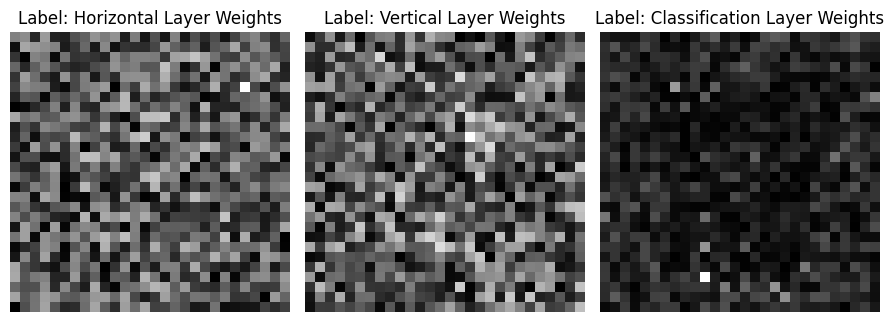

In [33]:
classification_w = np.abs(model.classification_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
vertical_w = np.abs(model.vertical_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
horizontal_w = np.abs(model.horizontal_layer.weight[0].reshape(28, 28).detach().cpu().numpy())

fig, axes = plt.subplots(1, 3, figsize=(9, 5))

visualize_image(horizontal_w, "Horizontal Layer Weights", ax=axes[0])
visualize_image(vertical_w, "Vertical Layer Weights", ax=axes[1])
visualize_image(classification_w, "Classification Layer Weights", ax=axes[2])

plt.tight_layout()
plt.show()

# Visualizing Activations

In [34]:
model.eval()
eval_examples = list()
with torch.no_grad():
    for idx, img in enumerate(test_images[:10]):
        img_tensor = torch.from_numpy(img.copy()).float().unsqueeze(0).unsqueeze(0).to('cuda')
        out, v_act, h_act = model(img_tensor)
        
        v_act_img = v_act.clone().reshape(28, 28).detach().cpu().numpy()
        h_act_img = h_act.clone().reshape(28, 28).detach().cpu().numpy()

        label = test_labels[idx]
        eval_examples.append((label, img, out, v_act_img, h_act_img))

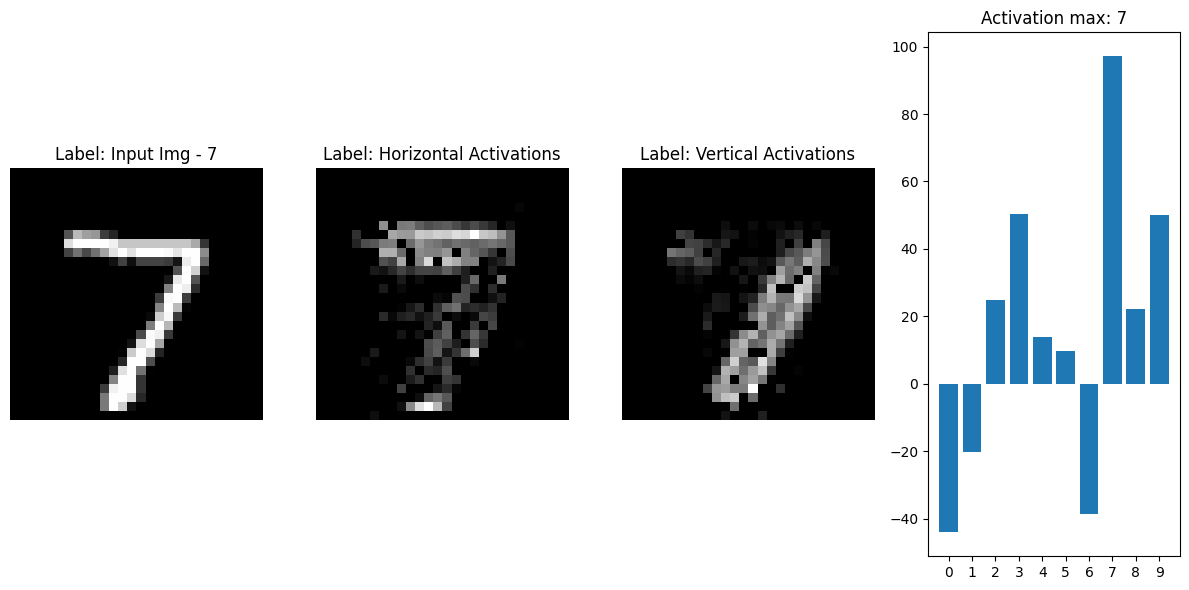

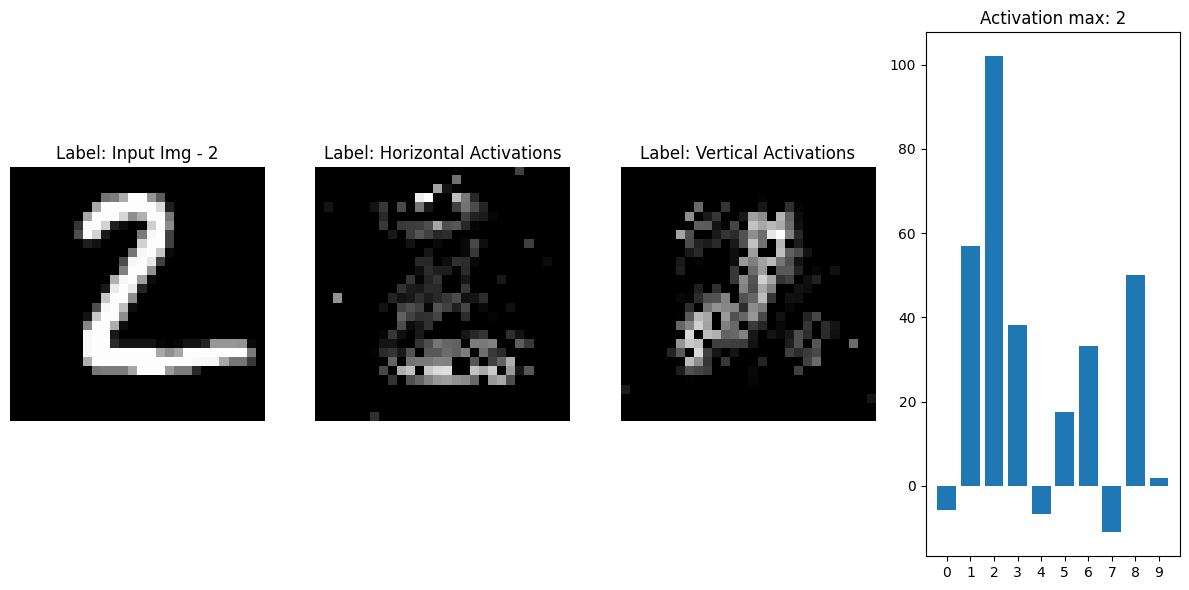

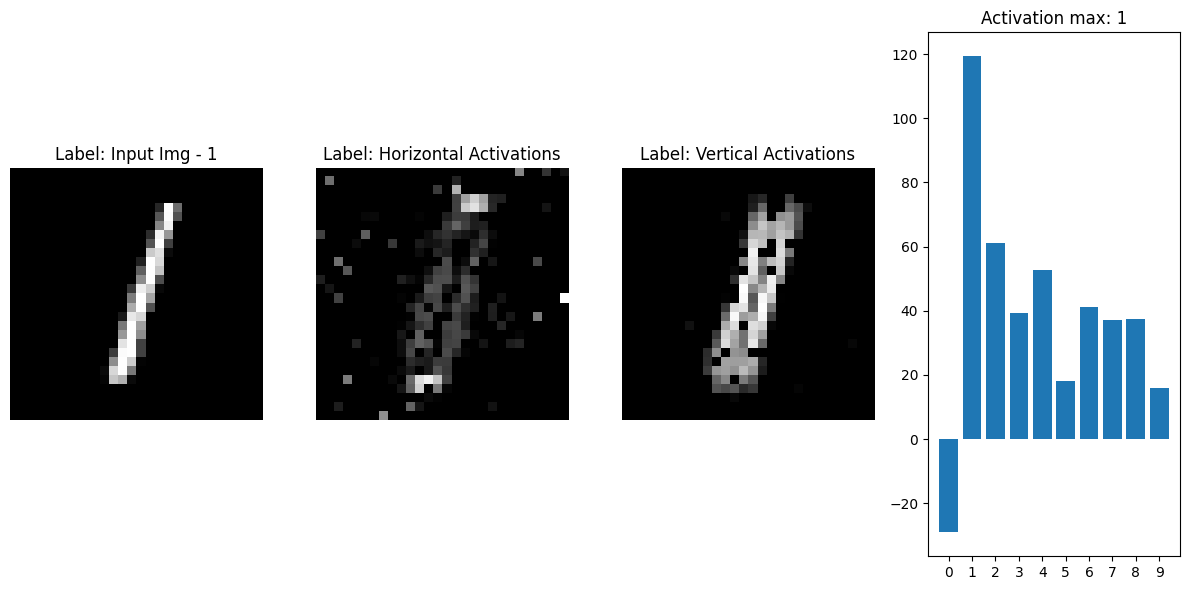

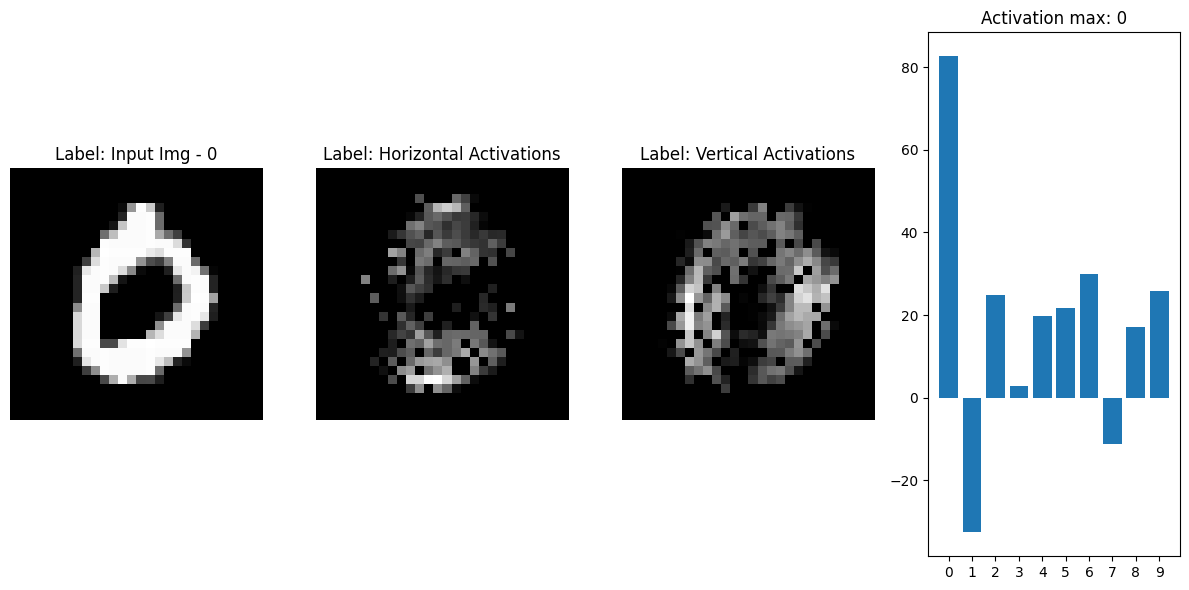

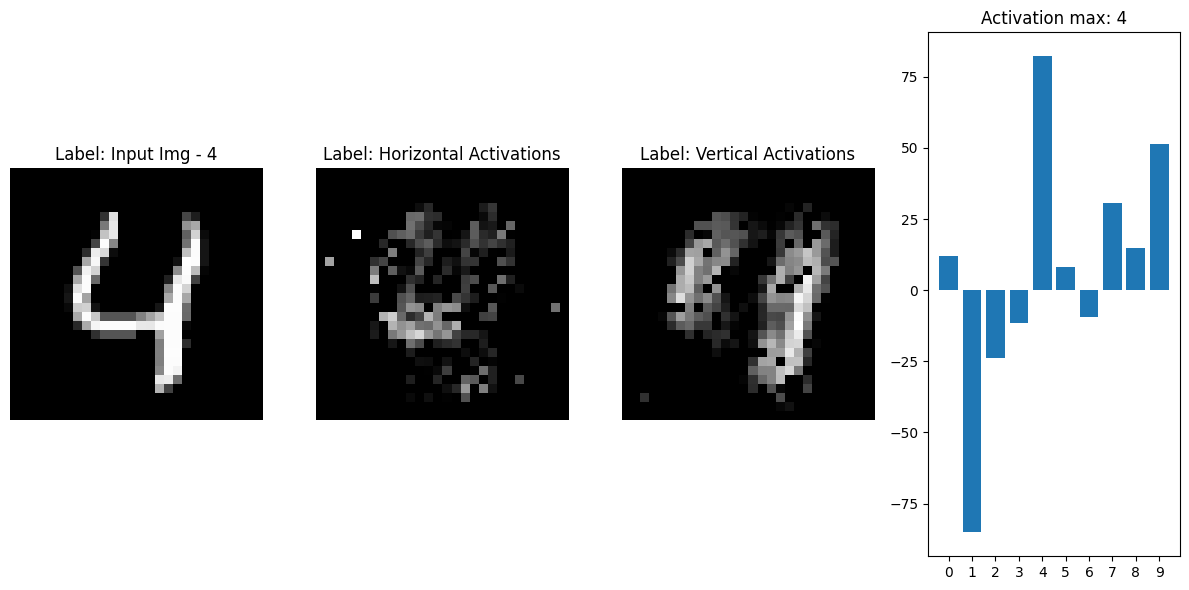

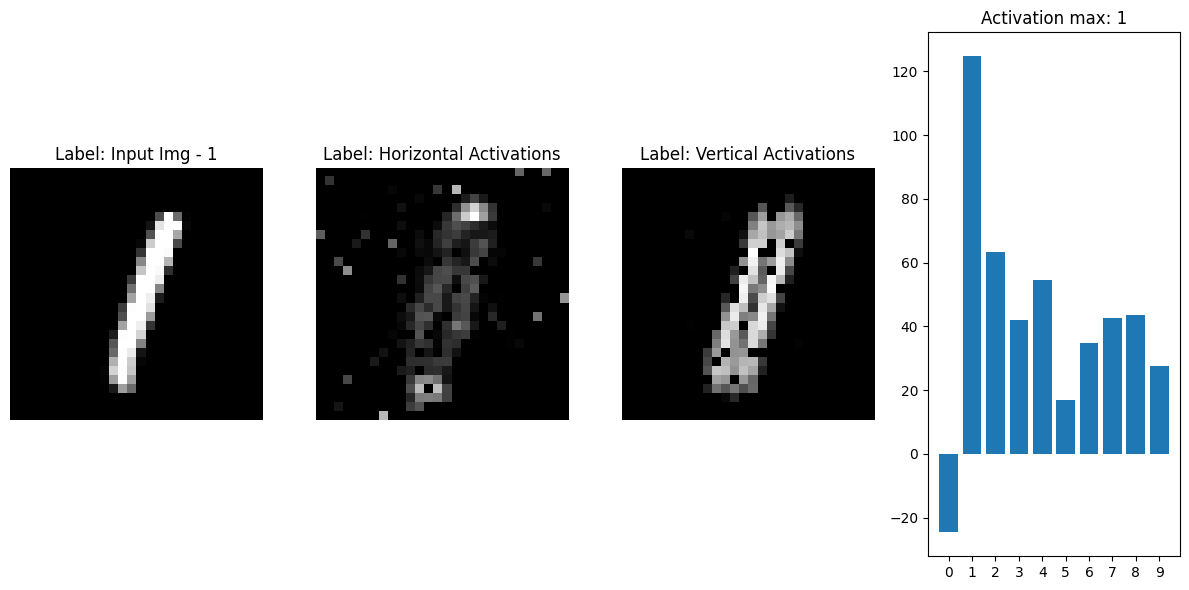

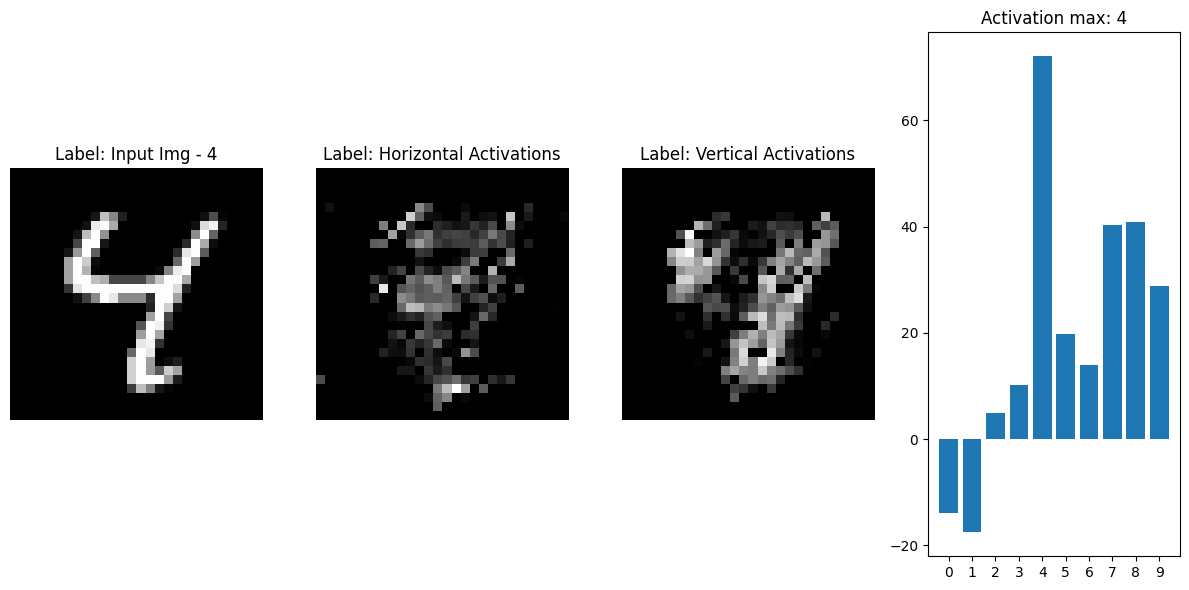

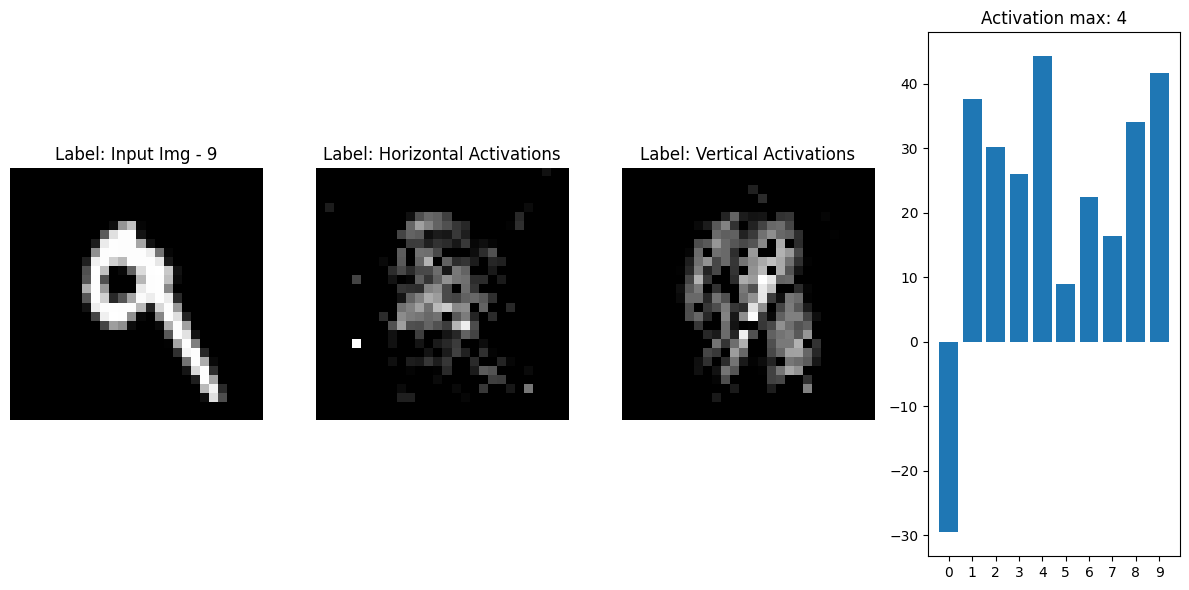

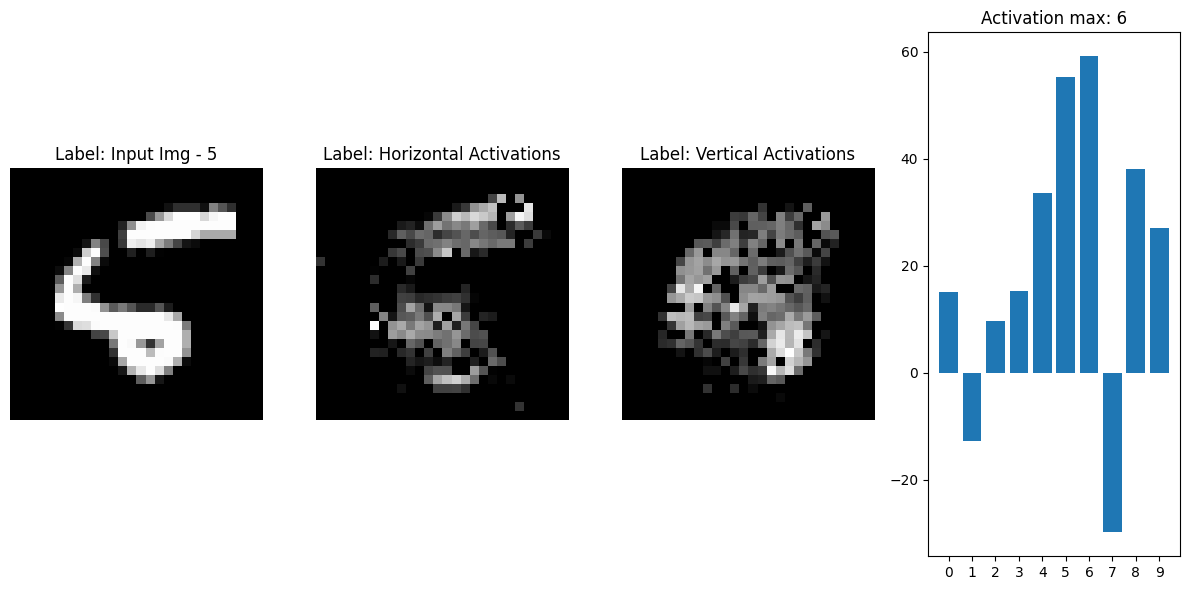

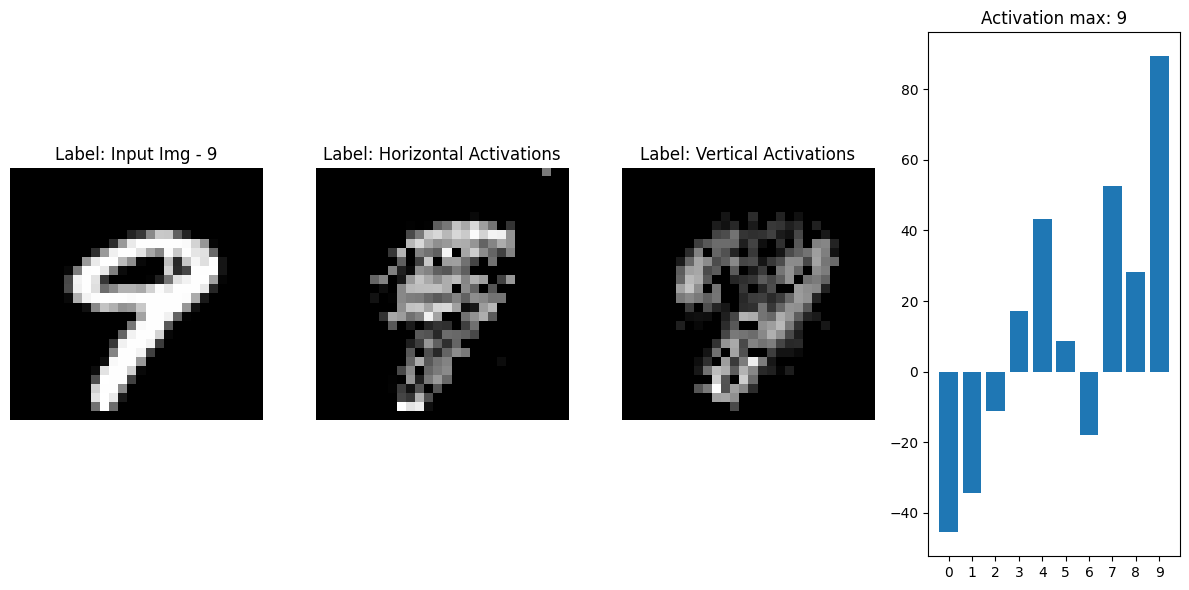

In [35]:
x_values = list(range(0, 10))
for label, img, out, v_act_img, h_act_img in eval_examples:
    inference = torch.max(out, 1)[1].item()
    fig, axes = plt.subplots(1, 4, figsize=(12, 6))

    visualize_image(img, f"Input Img - {label}", ax=axes[0])
    visualize_image(h_act_img, "Horizontal Activations", ax=axes[1])
    visualize_image(v_act_img, "Vertical Activations", ax=axes[2])

    ax3 = plt.subplot(1, 4, 4)
    bars3 = ax3.bar(x_values, out.tolist()[0])
    ax3.set_xticks(x_values)
    ax3.set_title(f"Activation max: {inference}")
    
    plt.tight_layout()
    plt.show()